In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import tomography
import torch
import torch.nn as nn
import torch.utils.data
import argparse
import time
import shutil
import glob
import os
import scipy.special as sp
from tqdm import tqdm_notebook

In [2]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, filename+'.best')
        

class dataset(torch.utils.data.Dataset):
    def __init__(self, n_training, n_layers_turbulence, n_total_heights, n_directions, n_zernike, fov, heights, DTel):
        super(dataset, self).__init__()
        
        self.n_training = n_training
        self.n_zernike = n_zernike
        self.n_layers_turbulence = n_layers_turbulence        
        self.n_directions = n_directions
        self.fov = fov
        self.heights = heights
        self.n_total_heights = len(self.heights)
        self.DTel = DTel

        self.mcao = tomography.tomography(self.n_directions, self.n_zernike, self.fov, self.heights, self.DTel, addPiston=True, npix=100)

    def __getitem__(self, index):

        alpha = np.random.randn(self.n_zernike, self.n_layers_turbulence)
        heights = np.random.permutation(self.heights)[0:self.n_layers_turbulence]
        beta = np.zeros((self.n_zernike, self.n_directions))

        for i in range(self.n_directions):
            for j in range(self.n_layers_turbulence):        
                beta[:,i] += self.mcao.M[:,:,heights[j],i] @ alpha[:,j]

        return beta.astype('float32')

    def __len__(self):
        return self.n_training

Let us define a very simple network:

In [8]:
class network(nn.Module):
    def __init__(self, n_zernike, n_directions, n_layers_DMs, batch_size):
        super(network, self).__init__()

        self.n_zernike = n_zernike
        self.n_directions = n_directions
        self.n_layers_DMs = n_layers_DMs
        self.batch_size = batch_size
        
        self.layer1 = nn.Linear(n_zernike*n_directions, 256)
        self.layer2 = nn.Linear(256, n_zernike*n_layers_DMs)
        self.relu = nn.ReLU()                
        
    def forward(self, x):

        out = self.layer1(x.view(self.batch_size, -1))
        out = self.layer2(out)        
        
        return out.view(self.batch_size, self.n_layers_DMs, self.n_zernike)

This class does the training.

In [9]:
class mcao_neural(object):
    def __init__(self, batch_size, n_layers_turbulence, n_training, n_validation, lr):

        self.cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.cuda else "cpu")
        self.batch_size = batch_size
        self.lr = lr

        # Define the properties of the telescope, FOV, etc.
        self.n_directions = 7
        self.n_zernike = 30
        self.fov = 60.0
        self.DTel = 4.0
        self.npix = 100
        self.n_layers_turbulence = n_layers_turbulence
        self.n_training = n_training
        self.n_validation = n_validation

        # Define all potential heights that can harbor turbulence or DMs
        self.heights = np.arange(15)
        self.n_total_heights = len(self.heights)

        # Instantiate the tomography class. This reads the projection matrix and defines
        # some useful functions
        self.mcao = tomography.tomography(self.n_directions, self.n_zernike, self.fov, self.heights, self.DTel, addPiston=True, npix=self.npix)

        self.M = torch.from_numpy(self.mcao.M.astype('float32')).to(self.device)

# Indices of the height vector on which we have a DM
        self.index_h_DMs = [0, 11]
        self.n_layers_DMs = len(self.index_h_DMs)

        torch.backends.cudnn.benchmark = True

        kwargs = {'num_workers': 1, 'pin_memory': True} if self.cuda else {}

        current_time = time.strftime("%Y-%m-%d-%H:%M:%S")
        self.out_name = 'trained/{0}'.format(current_time)

        self.model = network(self.n_zernike, self.n_directions, self.n_layers_DMs, self.batch_size).to(self.device)

        dset = dataset(self.n_training, self.n_layers_turbulence, self.n_total_heights, self.n_directions, self.n_zernike, self.fov, self.heights, self.DTel)
        self.train_loader = torch.utils.data.DataLoader(dset, batch_size=self.batch_size, shuffle=True, **kwargs)

        dset = dataset(self.n_validation, self.n_layers_turbulence, self.n_total_heights, self.n_directions, self.n_zernike, self.fov, self.heights, self.DTel)
        self.val_loader = torch.utils.data.DataLoader(dset, batch_size=self.batch_size, shuffle=True, **kwargs)

        
        self.loss_fn = nn.MSELoss().to(self.device)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def optimize(self, n_epochs):
        self.loss = []
        self.loss_val = []
        best_loss = -1e10
        self.n_epochs = n_epochs

        trainF = open('{0}.loss.csv'.format(self.out_name), 'w')

        print('Model : {0}'.format(self.out_name))

        for epoch in range(1, self.n_epochs + 1):
            self.train(epoch)
            self.test(epoch)

            trainF.write('{},{},{}\n'.format(
                epoch, self.loss[-1], self.loss_val[-1]))
            trainF.flush()

            is_best = self.loss_val[-1] < best_loss
            best_loss = min(self.loss_val[-1], best_loss)
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': self.model.state_dict(),
                'best_loss': best_loss,
                'optimizer': self.optimizer.state_dict(),
            }, is_best, filename='{0}.pth'.format(self.out_name))


        trainF.close()

    def train(self, epoch):
        self.model.train()

        print("Epoch {0}/{1}".format(epoch, self.n_epochs))
        t = tqdm_notebook(self.train_loader)
        loss_avg = 0.0
        n = 1

        for param_group in self.optimizer.param_groups:
            current_lr = param_group['lr']

        for batch_idx, (beta_turb) in enumerate(t):
            beta_turb = beta_turb.to(self.device)
            
            self.optimizer.zero_grad()

            d = self.model(beta_turb)

            d_flatten = d.view(-1,self.n_zernike)

            beta = beta_turb * 0.0

            for i in range(self.n_directions):
                for j in range(self.n_layers_DMs):
                    mat = self.M[:,:,self.index_h_DMs[j],i]
                    tmp = mat @ d[:,j,:].t()
                    beta[:,:,i] += tmp.t()

            loss = self.loss_fn(beta_turb, beta)
            
            loss_avg += (loss.item() - loss_avg) / n            
            n += 1

            loss.backward()

            self.optimizer.step()
            
            t.set_postfix(loss=loss.item(), loss_avg=loss_avg)
            
        self.loss.append(loss_avg)

    def test(self, epoch):
        self.model.eval()

        t = tqdm_notebook(self.val_loader)
        loss_avg = 0.0
        n = 1

        for param_group in self.optimizer.param_groups:
            current_lr = param_group['lr']

        for batch_idx, (beta_turb) in enumerate(t):
            beta_turb = beta_turb.to(self.device)
            
            d = self.model(beta_turb)

            beta = beta_turb * 0.0

            for i in range(self.n_directions):
                for j in range(self.n_layers_DMs):
                    mat = self.M[:,:,self.index_h_DMs[j],i]
                    tmp = mat @ d[:,j,:].t()
                    beta[:,:,i] += tmp.t()

            loss = self.loss_fn(beta_turb, beta)
            
            loss_avg += (loss.item() - loss_avg) / n            
            n += 1
                        
            t.set_postfix(loss=loss.item(), loss_avg=loss_avg)
            
        self.loss_val.append(loss_avg)

Train for only 10 epochs. The network seems to be not flexible enough but at least it is not overtraining.

In [10]:
mcao_network = mcao_neural(batch_size=64, n_layers_turbulence=2, n_training=1000*64, n_validation=50*64, lr=3e-4)
mcao_network.optimize(n_epochs=10)

-------------------------------------------------------------------
 - Zernike modes: 30
 - Number of heights : 15 -> [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.] km
 - FOV: 60.0 arcsec
 - Number of stars : 7
-------------------------------------------------------------------
Projection matrix exists : matrices/transformationMatrices_9ae2e132-aa14-457a-a9ea-96aaaecf1eae.npz
 - Zernike modes: 30
 - Number of heights : 15 -> [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.] km
 - FOV: 60.0 arcsec
 - Number of stars : 7
-------------------------------------------------------------------
 - Zernike modes: 30
 - Number of heights : 15 -> [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.] km
 - FOV: 60.0 arcsec
 - Number of stars : 7
-------------------------------------------------------------------
Projection matrix exists : matrices/transformationMatrices_9ae2e132-aa14-457a-a9ea-96aaaecf1eae.npz
 - Zernike modes: 30
 - Number of heights : 15 -> [ 0.


Epoch 2/10



Epoch 3/10



Epoch 4/10



Epoch 5/10



Epoch 6/10



Epoch 7/10



Epoch 8/10



Epoch 9/10



Epoch 10/10


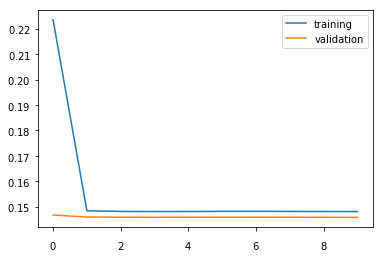

In [11]:
f, ax = pl.subplots()
ax.plot(np.array(mcao_network.loss), label='training')
ax.plot(np.array(mcao_network.loss_val), label='validation')
ax.legend()

Now do an experiment in which we put an atmosphere randomly with 2 metapupils and try to correct with the DMs.

In [12]:
def noll_indices(j):
  narr = np.arange(40)
  jmax = (narr+1)*(narr+2)/2
  wh = np.where(j <= jmax)
  n = wh[0][0]
  mprime = j - n*(n+1)/2
  if ((n % 2) == 0):
    m = 2*int(np.floor(mprime/2))
  else:
    m = 1 + 2*int(np.floor((mprime-1)/2))

  if ((j % 2) != 0):
    m *= -1

  return n, m

def _even(x):
    return x%2 == 0

def _zernike_parity(j, jp):
    return _even(j-jp)

class mcao_neural_validation(object):
    def __init__(self, checkpoint, batch_size, n_layers_turbulence, n_training, n_validation):

        self.cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.cuda else "cpu")
        self.batch_size = batch_size

        if (checkpoint is None):
            files = glob.glob('trained/*.pth')
            self.checkpoint = max(files, key=os.path.getctime)
            
        else:
            self.checkpoint = '{0}.pth'.format(checkpoint)

        # Define the properties of the telescope, FOV, etc.
        self.n_directions = 7
        self.n_zernike = 30
        self.fov = 60.0
        self.DTel = 4.0
        self.npix = 100
        self.n_layers_turbulence = n_layers_turbulence
        self.n_training = n_training
        self.n_validation = n_validation

        # Define all potential heights that can harbor turbulence or DMs
        self.heights = np.arange(15)
        self.n_total_heights = len(self.heights)

        # Instantiate the tomography class. This reads the projection matrix and defines
        # some useful functions
        self.mcao = tomography.tomography(self.n_directions, self.n_zernike, self.fov, self.heights, self.DTel, addPiston=True, npix=self.npix)

        self.M = torch.from_numpy(self.mcao.M.astype('float32')).to(self.device)

# Indices of the height vector on which we have a DM
        self.index_h_DMs = [0, 11]
        self.n_layers_DMs = len(self.index_h_DMs)

        torch.backends.cudnn.benchmark = True

        kwargs = {'num_workers': 1, 'pin_memory': True} if self.cuda else {}

        current_time = time.strftime("%Y-%m-%d-%H:%M:%S")
        self.out_name = 'trained/{0}'.format(current_time)

        self.model = network(self.n_zernike, self.n_directions, self.n_layers_DMs, self.batch_size).to(self.device)

        print("=> loading checkpoint '{}'".format(self.checkpoint))
        if (self.cuda):
            checkpoint = torch.load(self.checkpoint)
        else:
            checkpoint = torch.load(self.checkpoint, map_location=lambda storage, loc: storage)
        self.model.load_state_dict(checkpoint['state_dict'])        
        print("=> loaded checkpoint '{}'".format(self.checkpoint))
        
    def generate_turbulence(self, r0):
        
        covariance = np.zeros((self.n_zernike,self.n_zernike))
        for j in range(self.n_zernike):
            n, m = noll_indices(j+1)
            for jpr in range(self.n_zernike):
                npr, mpr = noll_indices(jpr+1)
                
                deltaz = (m == mpr) and (_zernike_parity(j, jpr) or m == 0)
                
                if (deltaz):                
                    phase = (-1.0)**(0.5*(n+npr-2*m))
                    t1 = np.sqrt((n+1)*(npr+1)) 
                    t2 = sp.gamma(14./3.0) * sp.gamma(11./6.0)**2 * (24.0/5.0*sp.gamma(6.0/5.0))**(5.0/6.0) / (2.0*np.pi**2)

                    Kzz = t2 * t1 * phase
                    
                    t1 = sp.gamma(0.5*(n+npr-5.0/3.0))
                    t2 = sp.gamma(0.5*(n-npr+17.0/3.0)) * sp.gamma(0.5*(npr-n+17.0/3.0)) * sp.gamma(0.5*(n+npr+23.0/3.0))
                    covariance[j,jpr] = Kzz * t1 / t2
        
                        
        covariance[0,0] = 1.0
        covariance[0,:] = 0.0
        covariance[:,0] = 0.0

        return np.random.multivariate_normal(np.zeros(self.n_zernike), covariance)

    def validate(self):
        self.model.eval()

        wfs = np.zeros((self.n_directions, self.npix, self.npix))
        loss = np.zeros(self.n_directions)
        mask = self.mcao.pupil == 1
        n_pixel = np.sum(mask)

        f, ax = pl.subplots(nrows=3, ncols=3, figsize=(13,8), constrained_layout=True)
        f2, ax2 = pl.subplots(nrows=3, ncols=3, figsize=(13,8), constrained_layout=True)
        ax = ax.flatten()
        ax2 = ax2.flatten()

        with torch.no_grad():
            
            alpha = np.zeros((self.n_zernike,self.n_layers_turbulence))
            alpha[:,0] = self.generate_turbulence(r0=5.0)
            alpha[:,1] = self.generate_turbulence(r0=5.0)

            alpha = torch.from_numpy(alpha.astype('float32')).to(self.device)
            heights = np.random.permutation(self.heights)[0:self.n_layers_turbulence]

            beta_turb = torch.zeros((1,self.n_zernike, self.n_directions)).to(self.device)

            for i in range(self.n_directions):
                for j in range(self.n_layers_turbulence):                    
                    tmp = self.M[:,:,heights[j],i] @ alpha[:,j]
                    beta_turb[0,:,i] += tmp
    
            d = self.model(beta_turb)

            beta = beta_turb * 0.0

            for i in range(self.n_directions):
                for j in range(self.n_layers_DMs):
                    mat = self.M[:,:,self.index_h_DMs[j],i]
                    tmp = mat @ d[:,j,:].t()
                    beta[:,:,i] += tmp.t()

            beta = beta_turb - beta
            alpha = alpha.cpu().numpy()
            beta = beta.cpu().numpy()
            beta_turb = beta_turb.cpu().numpy()
            d = d.cpu().numpy()

            for i in range(7):
                wfs[i,:,:] = self.mcao.to_wavefront(beta[0,:,i])
                loss[i] = np.sum(wfs[i,mask]**2) / n_pixel

                im = ax[i].imshow(wfs[i,:,:], cmap=pl.cm.viridis)
                ax[i].set_title('Corrected WF L={0:.2f}'.format(loss[i]))
                pl.colorbar(im, ax=ax[i])

                wfs[i,:,:] = self.mcao.to_wavefront(beta_turb[0,:,i])
                loss[i] = np.sum(wfs[i,mask]**2) / n_pixel

                im = ax2[i].imshow(wfs[i,:,:], cmap=pl.cm.viridis)        
                ax2[i].set_title('Original WF L={0:.2f}'.format(loss[i]))
                pl.colorbar(im, ax=ax2[i])

            for i in range(2):
                wfs[i,:,:] = self.mcao.to_wavefront(alpha[:,i])
                im = ax2[i+7].imshow(wfs[i,:,:], cmap=pl.cm.viridis)
                ax2[i+7].set_title('Turbulence metapupil h={0}'.format(heights[i]))
                pl.colorbar(im, ax=ax2[i+7])
                
                wfs[i,:,:] = self.mcao.to_wavefront(d[0,i,:])
                im = ax[i+7].imshow(wfs[i,:,:], cmap=pl.cm.viridis)
                ax[i+7].set_title('DMs h={0}'.format(self.index_h_DMs[i]))
                pl.colorbar(im, ax=ax[i+7])
        pl.tight_layout()

In [ ]:
mcao_network = mcao_neural_validation(checkpoint=None, batch_size=1, n_layers_turbulence=2, n_training=100*64, n_validation=10*64)
mcao_network.validate()

-------------------------------------------------------------------
 - Zernike modes: 30
 - Number of heights : 15 -> [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.] km
 - FOV: 60.0 arcsec
 - Number of stars : 7
-------------------------------------------------------------------
Projection matrix exists : matrices/transformationMatrices_9ae2e132-aa14-457a-a9ea-96aaaecf1eae.npz
 - Zernike modes: 30
 - Number of heights : 15 -> [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.] km
 - FOV: 60.0 arcsec
 - Number of stars : 7
=> loading checkpoint 'trained/2019-02-12-14:18:20.pth'
=> loaded checkpoint 'trained/2019-02-12-14:18:20.pth'


/scratch/miniconda3.7/envs/py37/lib/python3.7/site-packages/matplotlib/_constrained_layout.py:226: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  warnings.warn('constrained_layout not applied.  At least '
/scratch/miniconda3.7/envs/py37/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
